In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
X = df.drop(columns= 'country', axis= 0).values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_scaled = (X - X_mean) / X_std

In [4]:
class AgglomerativeClustering:
    
    def __init__(self, X):
        self.X = X
        self.n_samples = X.shape[0]
        self.linkage_matrix = []

    def aver_linkage_distance(self, cluster_A, cluster_B):
        distance = 0
        
        for i in range(len(cluster_A)):
            distance += np.linalg.norm(cluster_B - cluster_A[i, :], axis=1).sum()
        distance /= (len(cluster_A) * len(cluster_B))
        
        return distance
    
    def pairwise_distance(self):
    
        distance_matrix = np.zeros((self.n_samples, self.n_samples))
        
        for i in range(self.n_samples):
            for j in range(i + 1, self.n_samples):
                distance = np.linalg.norm(self.X[i] - self.X[j])
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance
                
        return distance_matrix

    def update(self, distance_matrix, labels):
    
        # Upper triangle (exclude diagonal)
        idx_upper = np.triu_indices(len(distance_matrix), k=1)
    
        # Index of minimum distance
        min_idx = np.argmin(distance_matrix[idx_upper])
        row = idx_upper[0][min_idx]
        col = idx_upper[1][min_idx]
        min_dist = distance_matrix[row, col]

        size = np.sum(labels == row) + np.sum(labels == col)
        self.linkage_matrix.append([row, col, min_dist, size])
        
        # Merge clusters
        labels[labels == col] = row
        labels[labels > col] -= 1
    
        # Delete row and column 'col'
        distance_matrix = np.delete(distance_matrix, col, axis=0)
        distance_matrix = np.delete(distance_matrix, col, axis=1)
    
        # Update distance matrix using average linkage
        for i in range(len(distance_matrix)):
            if i != row:
                d = self.aver_linkage_distance(
                    self.X[labels == row],
                    self.X[labels == i]
                )
                distance_matrix[row, i] = d
                distance_matrix[i, row] = d
    
        return distance_matrix, labels

    def fit(self):
        distance_matrix = self.pairwise_distance()
        np.fill_diagonal(distance_matrix, np.inf)
    
        labels = np.arange(self.n_samples)
    
        while len(distance_matrix) > 1:
            distance_matrix, labels = self.update(distance_matrix, labels)
    
        return np.array(self.linkage_matrix), labels

In [5]:
model = AgglomerativeClustering(X_scaled)
Z, labels = model.fit()

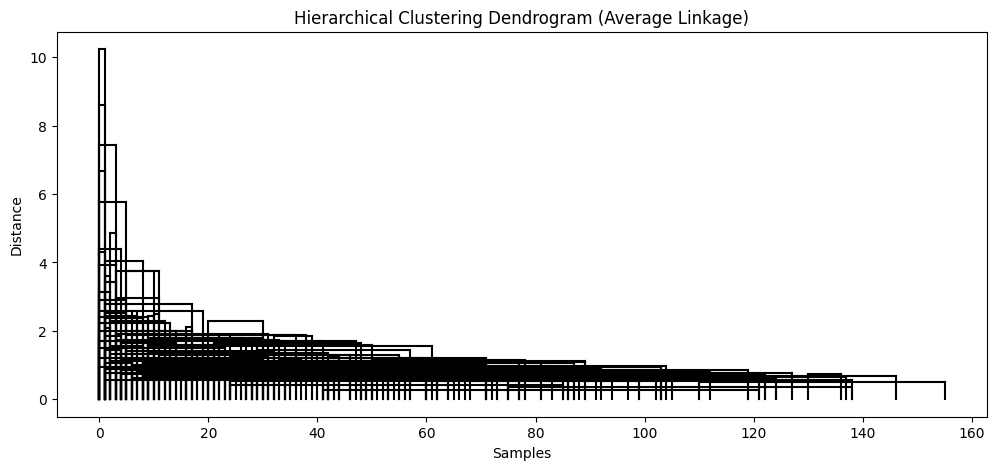

In [6]:
def plot_dendrogram(Z):
    plt.figure(figsize=(12, 5))
    
    current_x = {i: i for i in range(len(Z) + 1)}
    current_y = {i: 0 for i in range(len(Z) + 1)}
    
    for i, (c1, c2, dist, _) in enumerate(Z):
        c1, c2 = int(c1), int(c2)
        x1, x2 = current_x[c1], current_x[c2]
        y1, y2 = current_y[c1], current_y[c2]
        
        plt.plot([x1, x1], [y1, dist], c='k')
        plt.plot([x2, x2], [y2, dist], c='k')
        plt.plot([x1, x2], [dist, dist], c='k')
        
        current_x[len(Z) + i + 1] = (x1 + x2) / 2
        current_y[len(Z) + i + 1] = dist

    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.title("Hierarchical Clustering Dendrogram (Average Linkage)")
    plt.show()

plot_dendrogram(Z)

In [7]:
def get_clusters(Z, n_samples, k):
    labels = np.arange(n_samples)
    
    for i in range(n_samples - k):
        a, b = int(Z[i][0]), int(Z[i][1])
        labels[labels == b] = a
        labels[labels > b] -= 1
    
    return labels

k = 5
labels = get_clusters(Z, X.shape[0], k)

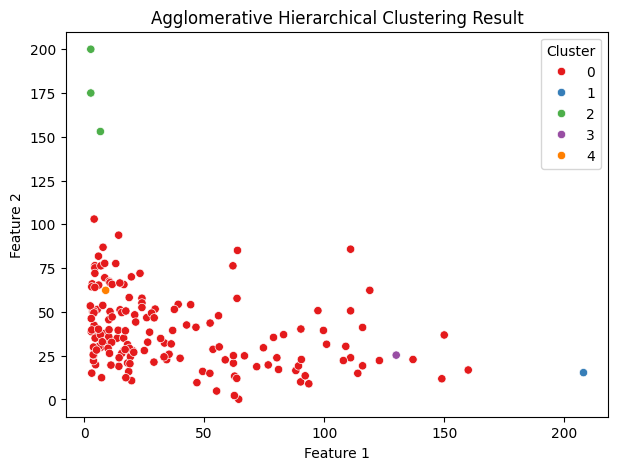

In [8]:
df_plot = pd.DataFrame(X[:, :2], columns=["Feature 1", "Feature 2"])
df_plot["Cluster"] = labels

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot,
    x="Feature 1",
    y="Feature 2",
    hue="Cluster",
    palette="Set1"
)
plt.title("Agglomerative Hierarchical Clustering Result")
plt.show()


In [12]:
cov_matrix = np.cov(X_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, idx]

X_pca = X_scaled @ eigenvectors[:, :2]

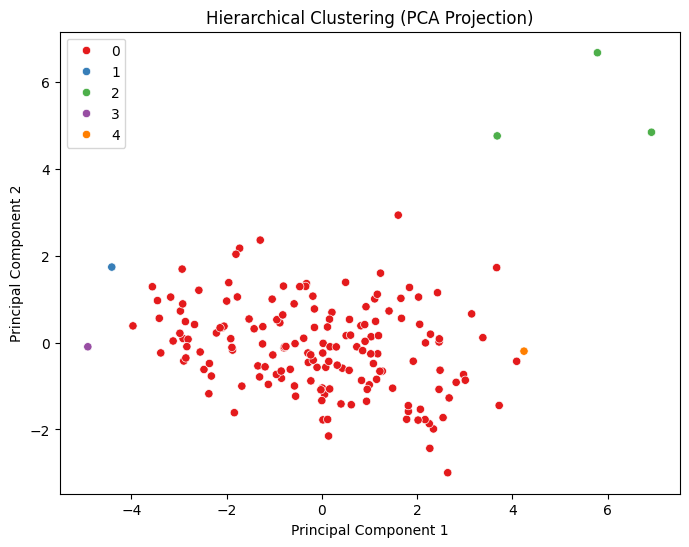

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=labels,
    palette='Set1'
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Hierarchical Clustering (PCA Projection)")
plt.show()

In [14]:
df2 = pd.DataFrame(X_scaled)
df2['Cluster'] = labels
df2.groupby('Cluster').mean()

,0,1,2,3,4,5,6,7,8
Cluster,,,,,,,,,
0,-0.020048,-0.087327,0.015250,-0.075799,-0.071380,-0.045464,0.004858,0.009497,-0.057173
1,4.221297,-0.944352,0.034438,0.737863,-0.813969,-0.221257,-4.337186,0.253120,-0.673215
2,-0.849003,4.935673,-0.008163,4.548058,2.439542,-0.504206,1.226824,-1.038863,2.440797
3,2.281385,-0.578452,-0.637438,-1.221785,-0.624065,9.129718,-1.134121,1.916133,-0.581936
4,-0.727966,0.775381,-1.827827,-0.956632,5.611542,-0.076082,1.008775,-0.581700,3.137608


In [18]:
dist_matrix = np.sqrt(
    np.sum((X_scaled[:, np.newaxis, :] - X_scaled[np.newaxis, :, :]) ** 2, axis=2)
)

silhouette_scores = []

for i in range(len(X_scaled)):
    same_cluster = labels == labels[i]
    other_clusters = labels != labels[i]

    # a(i): mean distance within same cluster
    a = np.mean(dist_matrix[i][same_cluster]) if np.sum(same_cluster) > 1 else 0

    # b(i): minimum mean distance to other clusters
    b = np.inf
    for c in np.unique(labels):
        if c != labels[i]:
            b = min(b, np.mean(dist_matrix[i][labels == c]))

    s = (b - a) / max(a, b)
    silhouette_scores.append(s)

silhouette_scores = np.array(silhouette_scores)
print("Mean Silhouette Score:", silhouette_scores.mean())

Mean Silhouette Score: 0.4108556724242746


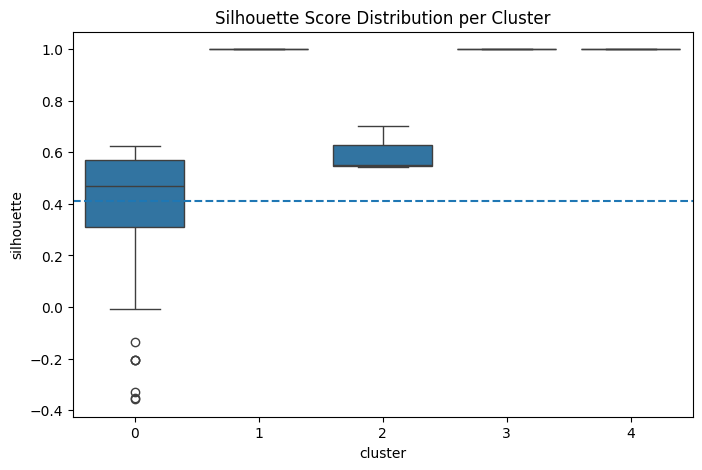

In [20]:
sil_df = pd.DataFrame({
    "silhouette": silhouette_scores,
    "cluster": labels
})

plt.figure(figsize=(8, 5))
sns.boxplot(x="cluster", y="silhouette", data=sil_df)
plt.axhline(silhouette_scores.mean(), linestyle='--')
plt.title("Silhouette Score Distribution per Cluster")
plt.show()